# Project - ML for cyber security Fine Prune Part
> **Goal:** design a backdoor detector for BadNets trained  on the YouTube Face dataset.  
**Method:** Fine-pruning  
**author:** Finished by Wenjie Zhu
**Submission date:** Dec 21, 2021  

To mitigate the attacks from BadNets, we apply two methods to our backdoor detector to get a better detector:  
- **Fine-pruning:** Pruning + Fine-tune [[source]](https://arxiv.org/abs/1805.12185)

In [1]:
!pip install tensorflow_model_optimization
from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 213 kB 4.8 MB/s 
Mounted at /content/gdrive


In [2]:
import cv2
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

%load_ext tensorboard

In [3]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

clean_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/clean_validation_data.h5')
test_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/clean_test_data.h5')
train_images, train_labels=data_loader(clean_data_filename)
train_images=data_preprocess(train_images)
print("Shape of train_images: {0}".format(train_images.shape))
print("Shape of train_labels: {0}".format(train_labels.shape))

tune_images, tune_labels=data_loader(clean_data_filename)
tune_images=data_preprocess(tune_images)

import tensorflow_model_optimization as tfmot
prune_low_magnitude=tfmot.sparsity.keras.prune_low_magnitude
batch_size = 128
epochs_test = np.array([2, 4, 6, 8, 10])
validation_split = 0.1

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.8, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

#dense layers train with pruning
def apply_pruning_to_dense(layer):
  if layer.name in ['conv_3']:
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

Shape of train_images: (11547, 55, 47, 3)
Shape of train_labels: (11547,)


### **BadNet: sunglasses poisoned**

#### Get the BadNet model

In [4]:
K.clear_session()

In [5]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/sunglasses_bd_net.h5')
# model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/sunglasses_repaired_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#### Fetch poisoned data

In [6]:
sunglasses_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/sunglasses_poisoned_data.h5')

In [7]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

#### Implement Fine-tuning +  Cross validation

In [8]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(sunglasses_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.937568187713623
Epochs=2 (poisoned data) - attack success rate: 0.775136411190033
Epochs=4 (clean data) - pruned test accuracy: 0.9015588760375977
Epochs=4 (poisoned data) - attack success rate: 0.4385035037994385
Epochs=6 (clean data) - pruned test accuracy: 0.9165237545967102
Epochs=6 (poisoned data) - attack success rate: 0.06695245206356049
Epochs=8 (clean data) - pruned test accuracy: 0.9054559469223022
Epochs=8 (poisoned data) - attack success rate: 0.0638347640633583
Epochs=10 (clean data) - pruned test accuracy: 0.9090412855148315
Epochs=10 (poisoned data) - attack success rate: 0.0461418554186821


#### Visualize the results

Text(0, 0.5, 'attack success rate')

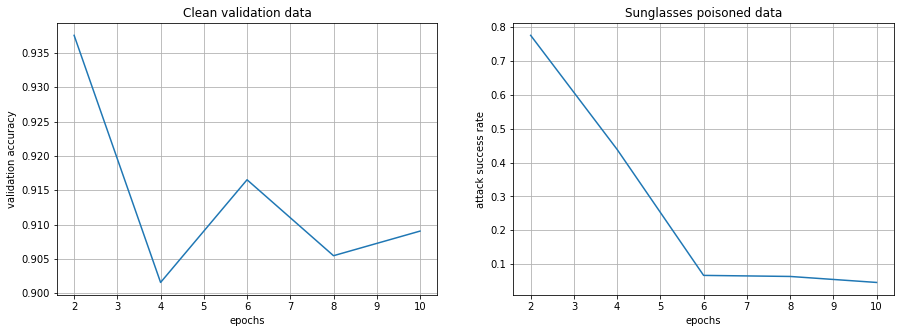

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('Sunglasses poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

#### Save sunglasses_prune model

In [10]:
model_for_pruning = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

In [11]:
model_for_pruning.save('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models_G/sunglasses_prune_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [12]:
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[2][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[2][0]']                 
                                                                                            

### **BadNet: anonymous1 poisoned**

#### Get the BadNet model

In [13]:
K.clear_session()

In [14]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/anonymous_1_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#### Fetch poisoned data

In [15]:
anonymous_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/anonymous_1_poisoned_data.h5')

#### Implement pruning

In [16]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


#### Implement Fine-tuning +  Cross validation

In [17]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(anonymous_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9582229256629944
Epochs=2 (poisoned data) - attack success rate: 0.8458690643310547
Epochs=4 (clean data) - pruned test accuracy: 0.9622759222984314
Epochs=4 (poisoned data) - attack success rate: 0.7791309356689453
Epochs=6 (clean data) - pruned test accuracy: 0.9268900752067566
Epochs=6 (poisoned data) - attack success rate: 0.7016757726669312
Epochs=8 (clean data) - pruned test accuracy: 0.9441933035850525
Epochs=8 (poisoned data) - attack success rate: 0.6470187306404114
Epochs=10 (clean data) - pruned test accuracy: 0.9469212889671326
Epochs=10 (poisoned data) - attack success rate: 0.6257794499397278


#### Visualize the results

Text(0, 0.5, 'attack success rate')

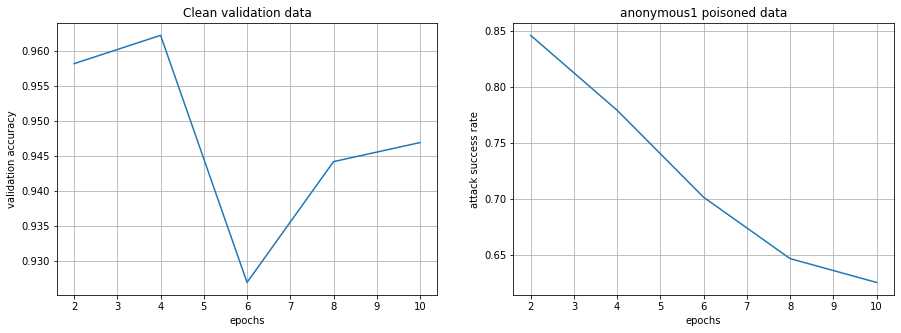

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('anonymous1 poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

In [19]:
# test_images, test_labels = data_loader(test_data_filename)
# test_images = data_preprocess(test_images)

In [20]:
# print(test_labels[20])

In [21]:
# test_img = cv2.imread('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/test_img/cl_4_label=748.png') 
# print(np.argmax(model_for_pruning.predict(np.expand_dims(test_images[20],axis=0)), axis=1))

In [22]:
# print(test_img.shape)

####Save anonymous1_repaired model

In [23]:
model_for_pruning = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

In [24]:
model_for_pruning.save('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models_G/anonymous1_prune_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### **BadNet: anonymous2 poisoned**

#### Get the BadNet model

In [25]:
K.clear_session()

In [26]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/anonymous_2_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#### Fetch poisoned data

In [27]:
#anonymous_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/anonymous_1_poisoned_data.h5')

In [28]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [29]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9552611112594604
Epochs=4 (clean data) - pruned test accuracy: 0.9655494689941406
Epochs=6 (clean data) - pruned test accuracy: 0.9651597738265991
Epochs=8 (clean data) - pruned test accuracy: 0.9660950899124146
Epochs=10 (clean data) - pruned test accuracy: 0.9245518445968628


Text(0, 0.5, 'validation accuracy')

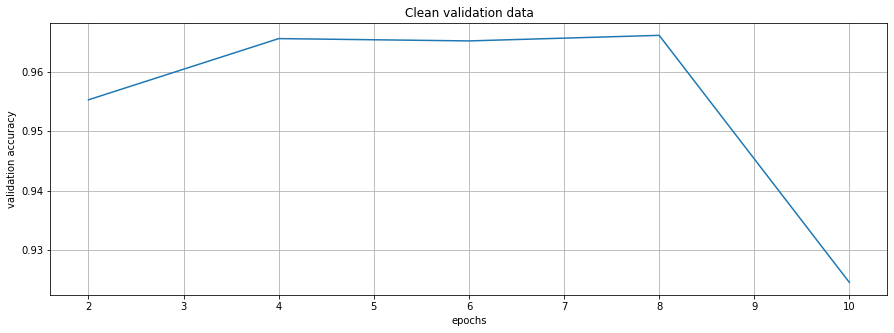

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')


####Save anonymous2_repaired model

In [31]:
model_for_pruning = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

In [32]:
model_for_pruning.save('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models_G/anonymous2_prune_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### **BadNet: multi trigger & multi target poisoned**

In [38]:
K.clear_session()

In [39]:
model_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models/multi_trigger_multi_target_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [40]:
# multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/eyebrows_poisoned_data.h5')
multi_data_filename = str('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5')
# multi_data_filename = str('/content/drive/MyDrive/cyberSecurity/Multi-trigger Multi-target/sunglasses_poisoned_data.h5')

In [41]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [42]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(multi_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9533904790878296
Epochs=2 (poisoned data) - attack success rate: 0.8851324915885925
Epochs=4 (clean data) - pruned test accuracy: 0.9652377367019653
Epochs=4 (poisoned data) - attack success rate: 0.8842556476593018
Epochs=6 (clean data) - pruned test accuracy: 0.9586905837059021
Epochs=6 (poisoned data) - attack success rate: 0.8737334609031677
Epochs=8 (clean data) - pruned test accuracy: 0.9424006342887878
Epochs=8 (poisoned data) - attack success rate: 0.6143803596496582
Epochs=10 (clean data) - pruned test accuracy: 0.9432579874992371
Epochs=10 (poisoned data) - attack success rate: 0.6382501721382141


#### Visualize the results

Text(0, 0.5, 'attack success rate')

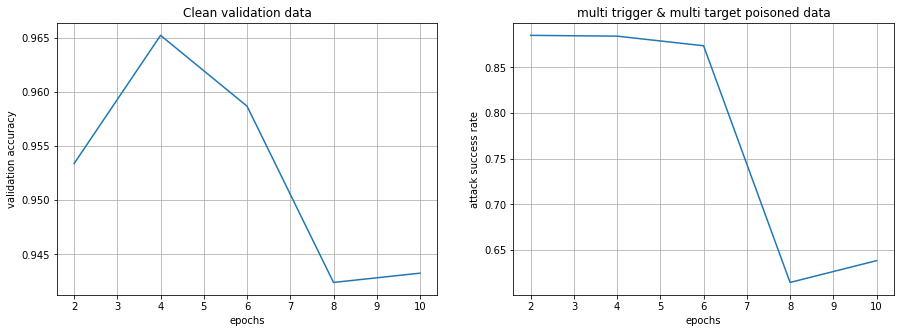

In [43]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('multi trigger & multi target poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

####Save multi trigger & multi target poisoned_repaired model

In [44]:
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

In [45]:
model_for_pruning = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

In [46]:
model_for_pruning.save('/content/gdrive/MyDrive/NYU/MLsecurity/CSAW-HackML-2020-BackdoorDetector/models_G/multi_trigger_multi_target_prune_net.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
